In [1]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt
from ipywidgets import Output, VBox, Label
from matplotlib.widgets import Cursor

import pandas as pd
import cv2
import os

In [2]:
%matplotlib widget

In [5]:
image_path = "C:/Users/CLOCKWORK/Desktop/MMU Files/Trimester 11 (FYP)/Code/temptest.jpg"

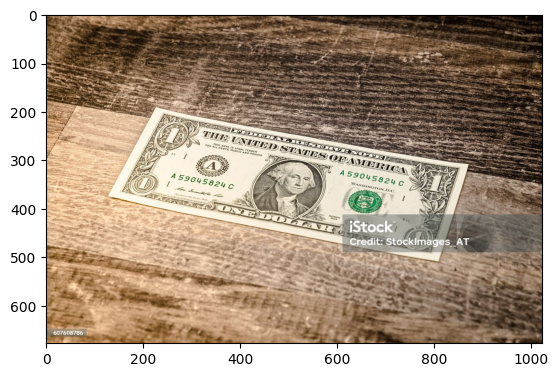

In [6]:
%matplotlib inline

image = cv2.imread(image_path)
median_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(median_rgb)
plt.show()

Output()

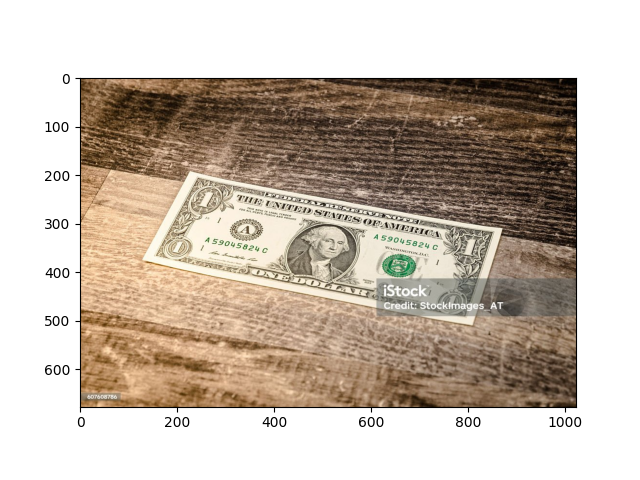

In [8]:
%matplotlib widget
clicked_points = []
img_pts = None  # This will store the final array
out = Output()

fig, ax = plt.subplots()
ax.imshow(median_rgb, cmap='gray')
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

display(out)

def onclick(event):
    global img_pts

    if event.inaxes != ax or len(clicked_points) >= 8:
        return

    # Record point
    x, y = event.xdata, event.ydata
    clicked_points.append((x, y))

    # Mark on the image
    ax.plot(x, y, 'ro')
    fig.canvas.draw()

    # When 8 points are selected, create img_pts and disconnect
    if len(clicked_points) == 8:
        img_pts = np.float32(clicked_points)
        print("Selected points:\n", img_pts)
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [9]:
#print coordinates
print(img_pts)

[[224.53226  191.09355 ]
 [125.435486 372.77097 ]
 [870.7258   310.83548 ]
 [808.79034  509.02902 ]
 [243.1129   193.15807 ]
 [845.9516   304.64194 ]
 [146.08064  381.02902 ]
 [779.8871   504.9     ]]


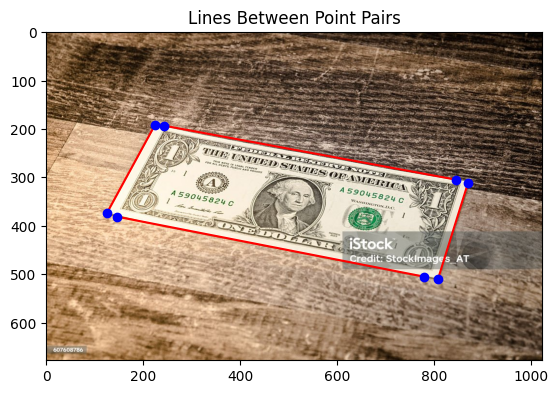

In [11]:
%matplotlib inline
# Plot image and lines
fig, ax = plt.subplots()
ax.imshow(median_rgb)

# Draw lines between point pairs
for i in range(0, len(img_pts), 2):
    pt1 = img_pts[i]
    pt2 = img_pts[i + 1]
    ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-')  # Red line
    ax.plot(pt1[0], pt1[1], 'bo')  # Blue point
    ax.plot(pt2[0], pt2[1], 'bo')

plt.title('Lines Between Point Pairs')
plt.show()


In [12]:
def affine_rectification(image, points):

    assert points.shape == (8, 2), "Points must be an array of shape (8, 2)."

    def get_line(p1, p2):
        return np.cross(np.append(p1, 1), np.append(p2, 1))

    # Get vanishing points from pairs of parallel lines
    line_pairs = [get_line(points[i], points[i+1]) for i in range(0, 8, 2)]
    vanishing_points = [np.cross(line_pairs[i], line_pairs[i+1]) for i in range(0, len(line_pairs), 2)]

    # Compute line at infinity as the cross product of vanishing points
    l_inf = np.cross(vanishing_points[0], vanishing_points[1])
    l_inf /= l_inf[2]  # Normalize

    # Construct the affine rectification homography
    H_affine = np.eye(3)
    H_affine[2] = l_inf

    # Compute new bounds to avoid cropping
    h, w = image.shape[:2]
    corners = np.array([
        [0, 0], [w, 0], [w, h], [0, h]
    ], dtype=np.float32)
    corners = corners.reshape(-1, 1, 2)
    corners_h = cv2.perspectiveTransform(corners, H_affine).reshape(-1, 2)

    x_min, y_min = np.floor(corners_h.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(corners_h.max(axis=0)).astype(int)

    translation = np.array([
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ])

    H_total = translation @ H_affine
    new_w, new_h = x_max - x_min, y_max - y_min
    rectified_img = cv2.warpPerspective(image, H_total, (new_w, new_h))

    return rectified_img

In [13]:
warped_image_affine = affine_rectification(median_rgb, img_pts)

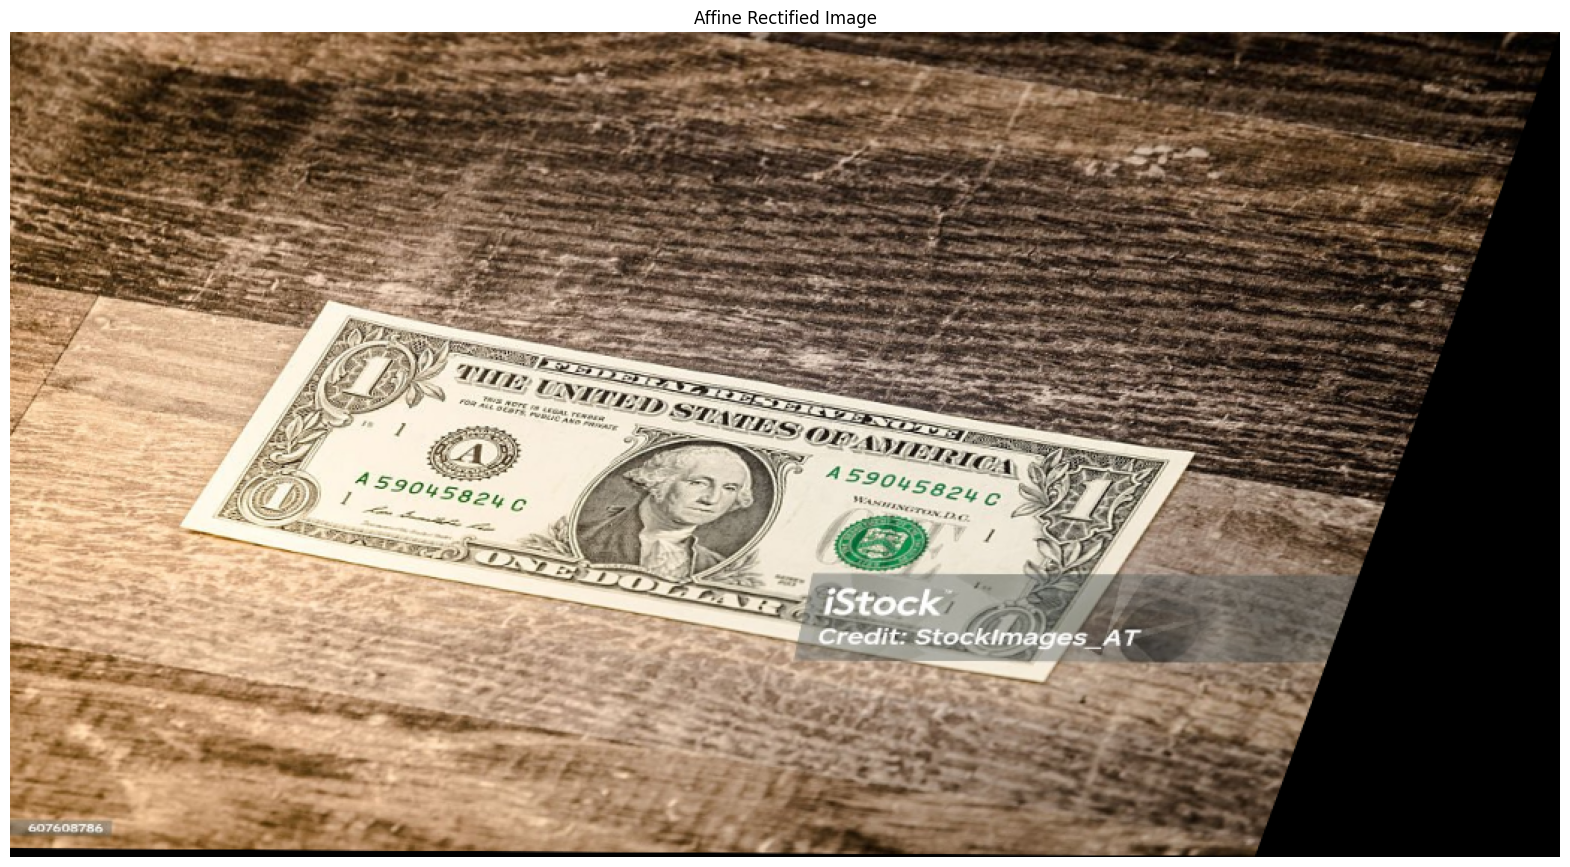

In [14]:
plt.figure(figsize=(20, 20))
plt.imshow(warped_image_affine)
plt.title("Affine Rectified Image")
plt.axis("off")
plt.show()

Output()

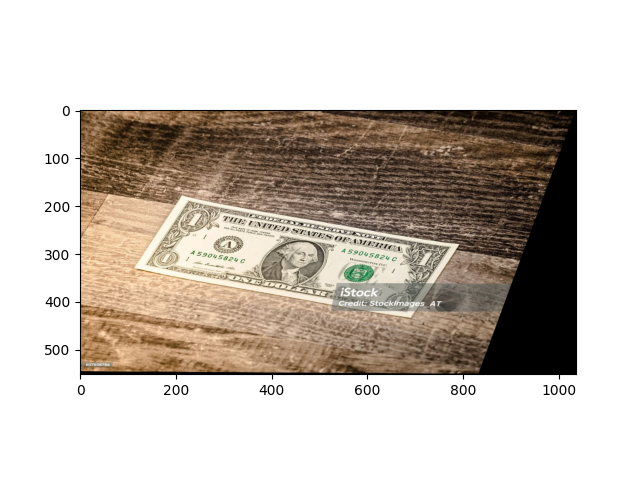

In [20]:
%matplotlib widget
clicked_points = []
affine_pts = None  # This will store the final array
out = Output()

fig, ax = plt.subplots()
ax.imshow(warped_image_affine, cmap='gray')
cursor = Cursor(ax, useblit=True, color='red', linewidth=1)

display(out)

def onclick(event):
    global affine_pts

    if event.inaxes != ax or len(clicked_points) >= 8:
        return

    # Record point
    x, y = event.xdata, event.ydata
    clicked_points.append((x, y))

    # Mark on the image
    ax.plot(x, y, 'ro')
    fig.canvas.draw()

    # When 8 points are selected, create affine_pts and disconnect
    if len(clicked_points) == 8:
        affine_pts = np.float32(clicked_points)
        print("Selected points:\n", affine_pts)
        fig.canvas.mpl_disconnect(cid)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

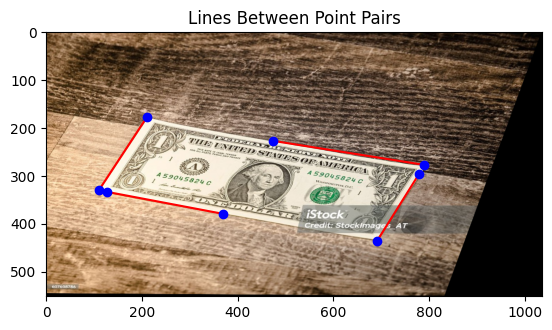

In [22]:
%matplotlib inline
# Plot image and lines
fig, ax = plt.subplots()
ax.imshow(warped_image_affine)

# Draw lines between point pairs
for i in range(0, len(affine_pts), 2):
    pt1 = affine_pts[i]
    pt2 = affine_pts[i + 1]
    ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'r-')  # Red line
    ax.plot(pt1[0], pt1[1], 'bo')  # Blue point
    ax.plot(pt2[0], pt2[1], 'bo')

plt.title('Lines Between Point Pairs')
plt.show()

In [23]:
def metric_rectification(image, points):

    assert points.shape == (8, 2), "Points must be an array of shape (8, 2)."

    def get_line(p1, p2):
        return np.cross(np.append(p1, 1), np.append(p2, 1))

    lines = [get_line(points[i], points[i+1]) for i in range(0, 8, 2)]

    # Normalize lines to handle direction ambiguity (normalize to unit length)
    lines = [l / np.linalg.norm(l[:2]) for l in lines]

    # Each pair of lines is orthogonal: l1^T * S * l2 = 0 where S is the symmetric matrix of the dual absolute conic
    # S = [[s11, s12],
    #      [s12, s22]]
    # For l = [a, b, c], we extract [a, b] for calculation

    equations = []
    for i in range(0, len(lines), 2):
        l1 = lines[i][:2]
        l2 = lines[i+1][:2]
        equation = [l1[0]*l2[0], l1[0]*l2[1] + l1[1]*l2[0], l1[1]*l2[1]]
        equations.append(equation)

    A = np.array(equations)
    _, _, Vt = np.linalg.svd(A)
    s = Vt[-1]

    S = np.array([[s[0], s[1]], [s[1], s[2]]])

    # Cholesky decomposition of S (or S must be positive definite)
    try:
        K_inv_T = np.linalg.cholesky(S).T
    except np.linalg.LinAlgError:
        # Use SVD to approximate square root if Cholesky fails
        U, D, Vt = np.linalg.svd(S)
        sqrt_D = np.diag(np.sqrt(D))
        K_inv_T = U @ sqrt_D @ Vt

    H_metric = np.eye(3)
    H_metric[:2, :2] = np.linalg.inv(K_inv_T)

    # Compute new bounds to avoid cropping
    h, w = image.shape[:2]
    corners = np.array([
        [0, 0], [w, 0], [w, h], [0, h]
    ], dtype=np.float32)
    corners_h = cv2.perspectiveTransform(corners.reshape(-1, 1, 2), H_metric).reshape(-1, 2)

    x_min, y_min = np.floor(corners_h.min(axis=0)).astype(int)
    x_max, y_max = np.ceil(corners_h.max(axis=0)).astype(int)

    translation = np.array([
        [1, 0, -x_min],
        [0, 1, -y_min],
        [0, 0, 1]
    ])

    H_total = translation @ H_metric
    new_w, new_h = x_max - x_min, y_max - y_min
    rectified_img = cv2.warpPerspective(image, H_total, (new_w, new_h))

    return rectified_img

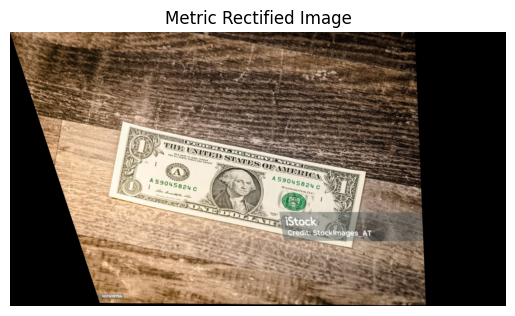

In [24]:
warped_image_metric = metric_rectification(warped_image_affine, affine_pts)

plt.imshow(warped_image_metric)
plt.title("Metric Rectified Image")
plt.axis("off")
plt.show()

In [25]:
#img_rgb = cv2.cvtColor(warped_image_metric, cv2.COLOR_BGR2RGB)
#cv2.imwrite('output_rgb.jpg', img_rgb)